In [2]:
# MODULE IMPORTS
from rocketpy import Environment, SolidMotor, Rocket, Flight
import datetime
from math import pi, pow

# Global Parameters

In [1]:
# Rocket Dimension & Mass Properties
#       You can get the Mass and CG values from the OpenRocket model
#       click Tools > Component analysis
#       Note that the mass should be without the motor

#       To get the inertias you can go to the simulation tab and export the
#       longitudinal and lateral inertias as a function of time
rocket_diameter_mm = 6.0 * 25.43 
rocket_mass_oz = 646
rocket_mass_kg = (rocket_mass_oz / 16) / 2.20462
rocket_inertia_xx_yy_kgpm2 = 29.871
rocket_inertia_zz_kgpm2 = 0.128
rocket_center_of_mass_in = 63.027
rocket_coordinate_system_orientation = "nose_to_tail"

# Fin Parameters
shear_modulus_psi = 20_000
semi_span_in = 6.25              
root_chord_in = 15.0
tip_chord_in = 7.0
thickness_in = 3/8
fin_area_in2 = 0.5 * (root_chord_in + tip_chord_in) * semi_span_in
aspect_ratio = semi_span_in**2 / fin_area_in2
chord_ratio = tip_chord_in / root_chord_in

def temp_at_alt_F(alt_ft):
    return 59 - 0.00356 * alt_ft

def pres_lbspin2(temp_F):
    return (2116 / 144) * ((temp_F + 459.7) / 518.6)**5.256

def sound_speed_ftps(temp_F):
    return (1.4 * 1716.59 * (temp_F + 460))**2

def fin_flutter_velocity_ftpsec(sound_speed_ftps, shear_modulus_psi, aspect_ratio, pres_lbspin2, chord_ratio,
                                thickness_in, root_chord_in):
    return sound_speed_ftps * \
    ((shear_modulus_psi / (1.337 * aspect_ratio**3 * pres_lbspin2 * (chord_ratio + 1))) \
     /(2 * (aspect_ratio + 2) * (thickness_in / root_chord_in)))**(1/2)


# Rocket Aerodynamic Properties (Power On/Off Drag Can be Downloaded from RASAero)
rocket_power_off_drag_file_location = ""
rocket_power_on_drag_file_location = ""
#       alternatively, you can just call this function, which returns the
#       drag coeff as a function of mach
def rocket_drag(mach):
    return 0.54


# Data from ThrustCurve for M2000R
motor_thrust_file = "C:/Code/SA2023/data/AeroTech_M2000R.eng"
motor_diameter_mm = 98
motor_length_mm = 732
motor_total_weight_g = 8_987
motor_prop_weight_g = 5_368

# Initial Conditions
initial_height_m = 1400.0

68.75
0.5681818181818182


# Environment Definition


Gravity Details

Acceleration of Gravity at Lauch Site: 9.79133308624842 m/s²


Launch Site Details

Launch Date: 2023-11-11 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1400.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 856.02 hPa
Surface Temperature: 279.07 K
Surface Air Density: 1.069 kg/m³
Surface Speed of Sound: 334.55 m/s


Atmospheric Model Plots



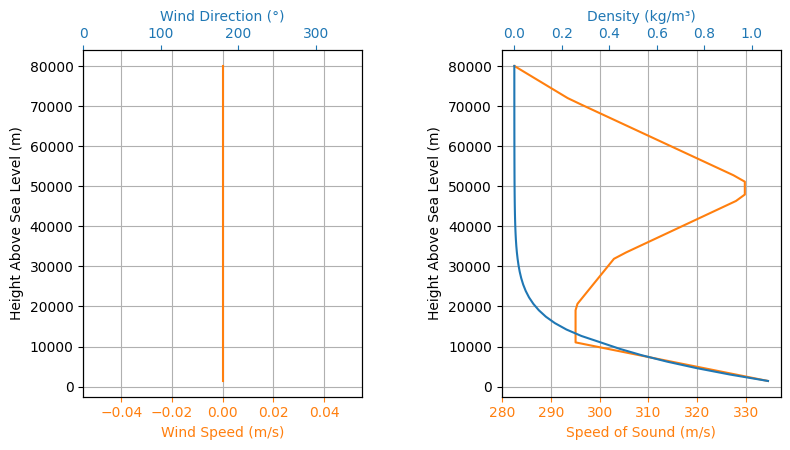

In [4]:
# Initialize Environment Object
#   This location roughly corresponds to the Spaceport America Launch Site
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=initial_height_m)

# Example of using predicted winds
tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time

# The line below takes ~20s to run because it's pulling
# a wind forecast from a server/website
#env.set_atmospheric_model(type="Forecast", file="GFS")

env.info()

# Defining our Motor
We need info about the grain of our motor, which do not have/haven't calculated yet. These numbers are best guesses at the moment.

https://www.thrustcurve.org/motors/AeroTech/M2000R/

https://www.apogeerockets.com/Rocket_Motors/Rouse-Tech_Casings/98mm_Casings/RMS-98_10240_Casing

0.1659401975
0.008689219000000001
Nozzle Details
Nozzle Radius: 0.033 m
Nozzle Throat Radius: 0.011 m

Grain Details
Number of Grains: 4
Grain Spacing: 0.0 m
Grain Density: 1072.735523290961 kg/m3
Grain Outer Radius: 0.049 m
Grain Inner Radius: 0.015 m
Grain Height: 0.183 m
Grain Volume: 0.001 m3
Grain Mass: 1.342 kg

Motor Details
Total Burning Time: 5.0 s
Total Propellant Mass: 5.368 kg
Average Propellant Exhaust Velocity: 1711.307 m/s
Average Thrust: 1837.259 N
Maximum Thrust: 2316.158 N at 1.974 s after ignition.
Total Impulse: 9186.297 Ns



c:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\rocketpy\motors\motor.py:910: UserWarning: burn_time argument (0, 5.0) is out of thrust source time range. Using thrust_source boundary times instead: (0, 4.799) s.
If you want to change the burn out time of the curve please use the 'reshape_thrust_curve' argument.
  warnings.warn(


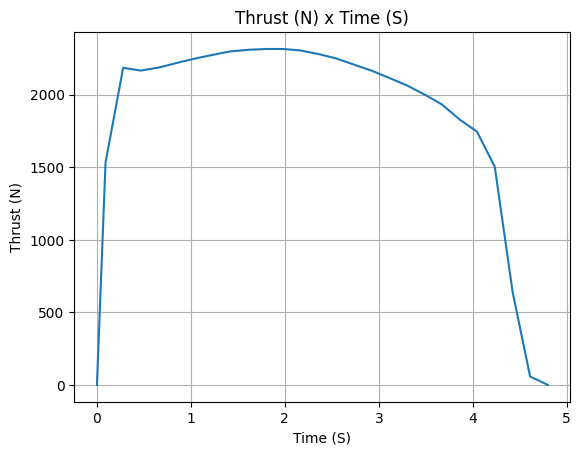

In [5]:
# Dry Mass (mass of motor without propellant)
motor_dry_mass_kg = (motor_total_weight_g - motor_prop_weight_g) / 1000

# Dry Inertia (inertia of motor without propellant)
#       Essentially just the inertia of the motor case
#       which is assumed to be cylindrical shell
motor_dry_inertia_xx_yy = motor_dry_mass_kg * \
    ((1/2) * (motor_diameter_mm / 2000)**2 + (1/12) * (motor_length_mm / 1000)**2)
motor_dry_inertia_zz = motor_dry_mass_kg * (motor_diameter_mm / 2000)**2.0
print(motor_dry_inertia_xx_yy) #looks reasonable
print(motor_dry_inertia_zz)

# Grain Info
motor_grain_count = 4
motor_grain_inner_diameter_mm = 15 * 2 # guestimate
motor_grain_volume_m3 = (pi / 4) * (motor_length_mm / 1000) * \
    ((motor_diameter_mm / 1000)**2 - (motor_grain_inner_diameter_mm / 1000)**2)
motor_grain_density_kgpm3 = (motor_prop_weight_g / 1000) / motor_grain_volume_m3
#print(motor_grain_volume_m3) # reasonable, can check against the motor.info() output
#print(motor_grain_density_kgpm3)



# These require SI units (kg, m)
#       Nozzle Radius, 
#       Assumes center of dry and wet mass are the same (half of motor length)
AeroTechM2000R = SolidMotor(
    thrust_source = motor_thrust_file,
    dry_mass = motor_dry_mass_kg,
    dry_inertia=(motor_dry_inertia_xx_yy, motor_dry_inertia_xx_yy, motor_dry_inertia_zz),
    nozzle_radius=33 / 1000,
    grain_number=motor_grain_count,
    grain_density=motor_grain_density_kgpm3,
    grain_outer_radius=(motor_diameter_mm / 2000),
    grain_initial_inner_radius=(motor_grain_inner_diameter_mm / 2000),
    grain_initial_height=(motor_length_mm / 1000) / motor_grain_count,
    grain_separation=0 / 1000,
    grains_center_of_mass_position=(motor_length_mm / 2000),
    center_of_dry_mass_position=(motor_length_mm / 2000),
    nozzle_position=0,
    burn_time=5.0,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

AeroTechM2000R.info()
#AeroTechM2000R.all_info()

# Defining our Rocket



Inertia Details

Rocket Mass: 18.314 kg
Rocket Dry Mass: 21.933 kg (With Motor)
Rocket Mass: 27.301 kg (With Propellant)
Rocket Inertia (with motor, but without propellant) 11: 32.434 kg*m2
Rocket Inertia (with motor, but without propellant) 22: 32.434 kg*m2
Rocket Inertia (with motor, but without propellant) 33: 0.137 kg*m2
Rocket Inertia (with motor, but without propellant) 12: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 13: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 23: 0.000 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.07629 m
Rocket Frontal Area: 0.018285 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass withour Motor: 0.147 m
Rocket Center of Dry Mass - Nozzle Exit Distance: 1.110 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.744 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.146 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coeff

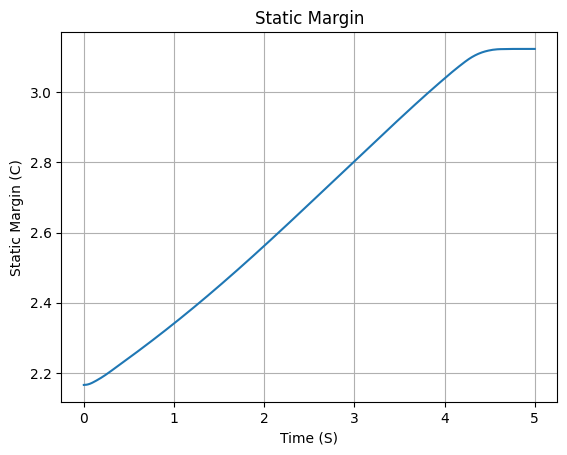

In [6]:
Sabre_1 = Rocket(
    radius = rocket_diameter_mm / 2000,
    mass = rocket_mass_kg,
    inertia = (rocket_inertia_xx_yy_kgpm2, rocket_inertia_xx_yy_kgpm2, rocket_inertia_zz_kgpm2),
    power_off_drag = rocket_drag(float),
    power_on_drag = rocket_drag(float),
    center_of_mass_without_motor= (rocket_center_of_mass_in * 0.0254),
    coordinate_system_orientation=rocket_coordinate_system_orientation,
)

Sabre_1.add_motor(AeroTechM2000R, position=112.5*0.0254)

rail_buttons = Sabre_1.set_rail_buttons(
    upper_button_position = 65 * 0.0254,
    lower_button_position = 90 * 0.0254,
    angular_position=45,
)

nose_cone = Sabre_1.add_nose(
    length = 23 * 0.0254,
    kind = "von karman",
    position = 0.0
)

fin_set = Sabre_1.add_trapezoidal_fins(
    n=4,
    root_chord=(15 * 0.0254),
    tip_chord=(7 * 0.0254),
    span=(6.25 * 0.0254),
    position=(95 * 0.0254),
    cant_angle=0.0,
    sweep_angle=64.1,
    airfoil=None,
)

Sabre_1.info()
Sabre_1.plots.static_margin()

Nominal Apogee: 3224.0594913115265 m, 10577.62334147451 ft


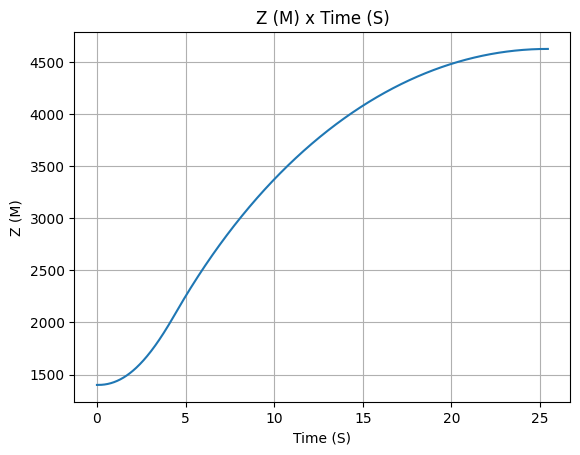


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1400.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.052 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -6.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.1816  m
Launch Rail Inclination: 84.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.426 s
Rail Departure Velocity: 23.194 m/s
Rail Departure Static Margin: 2.228 c
Rail Departure Angle of Attack: -0.000°
Rail Departure Thrust-Weight Ratio: 8.239
Rail Departure Reynolds Number: 2.169e+05


Burn out State

Burn out time: 5.000 s
Altitude at burn out: 850.897 m (AGL)
Rocket velocity at burn out: 283.295 m/s
Freestream velocity at burn out: 283.295 m/s
Mach Number at burn out: 0.856
Kinetic energy at burn out

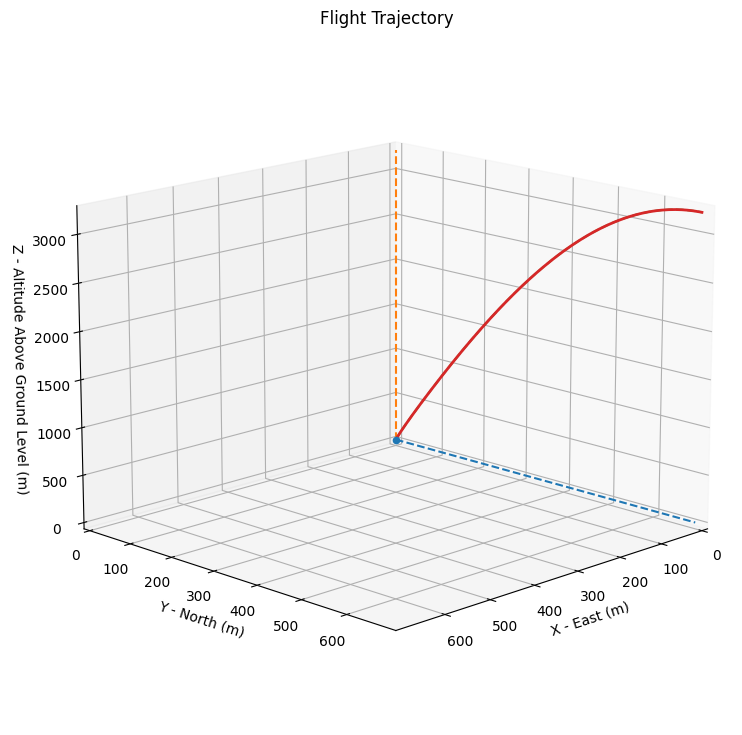



Trajectory Kinematic Plots



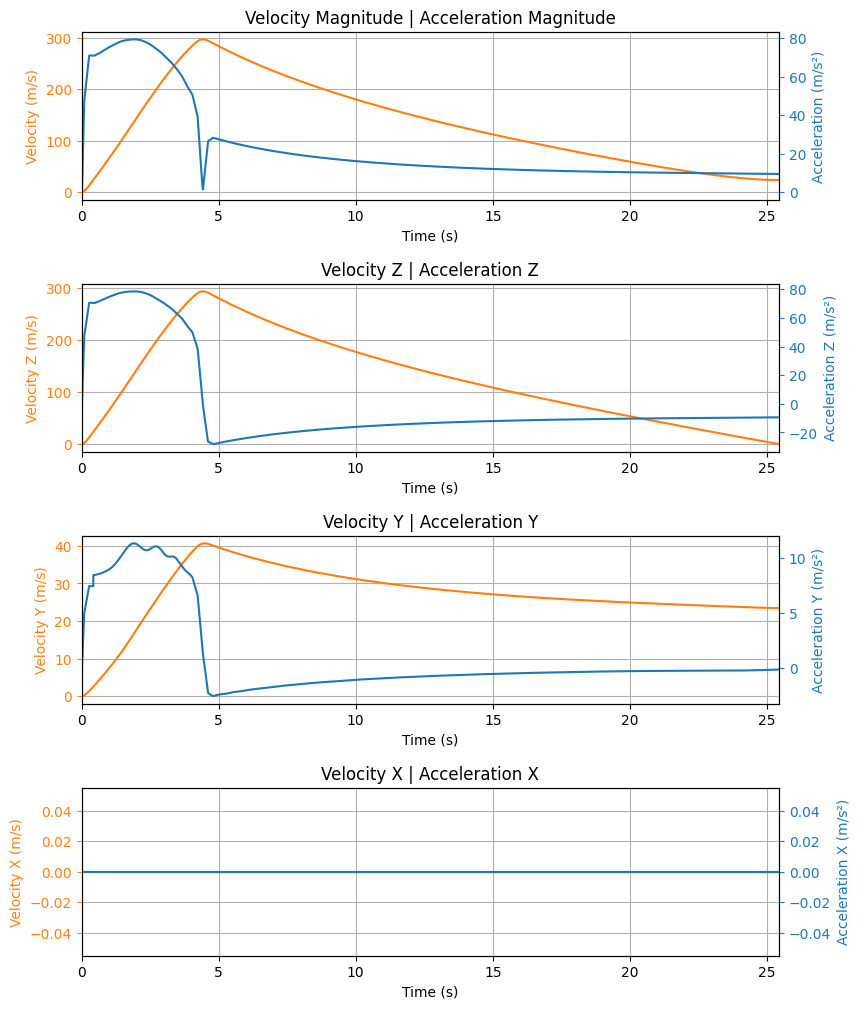



Angular Position Plots



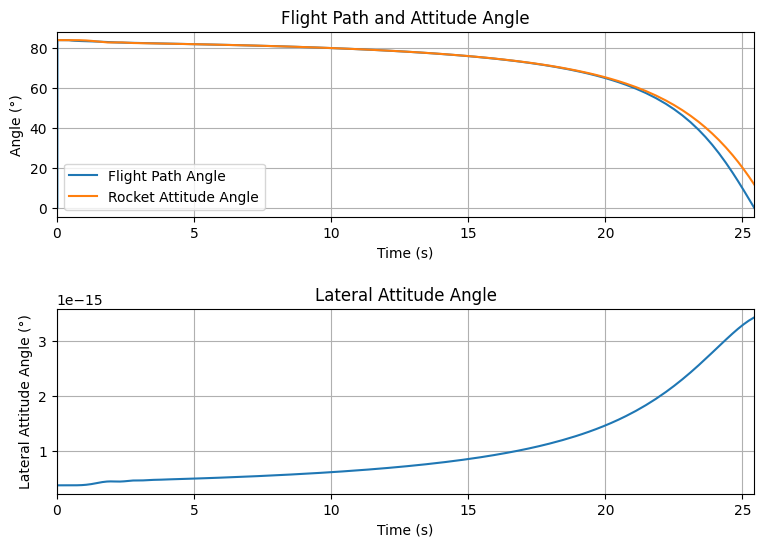



Path, Attitude and Lateral Attitude Angle plots



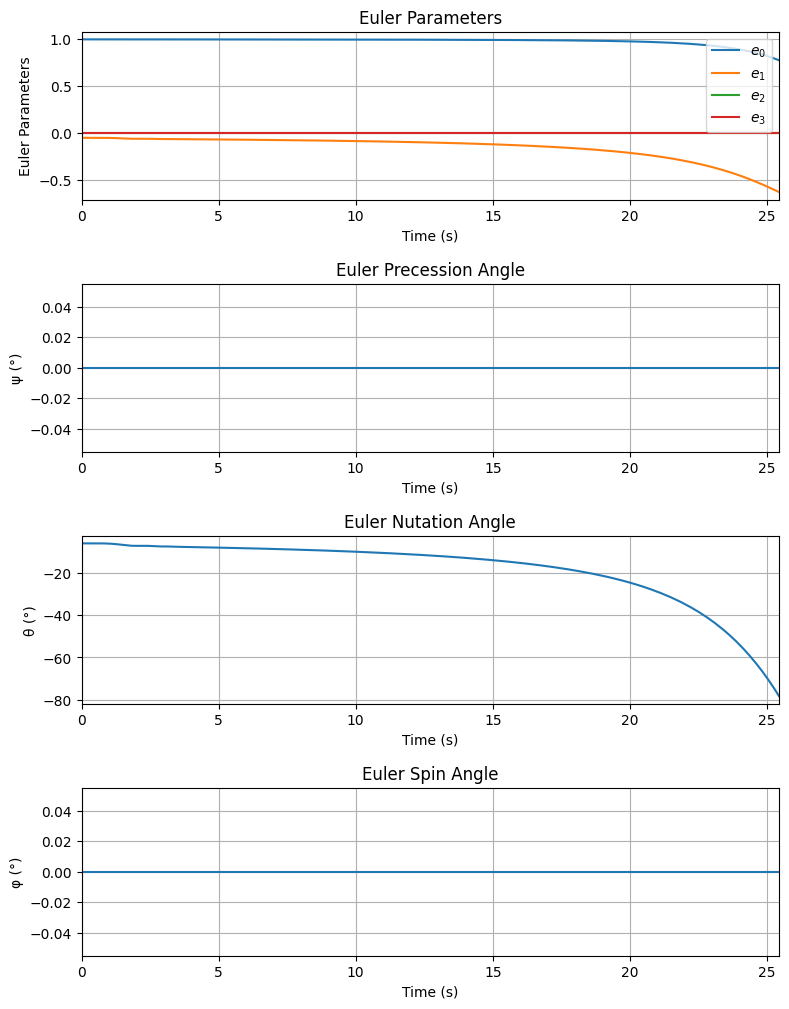



Trajectory Angular Velocity and Acceleration Plots



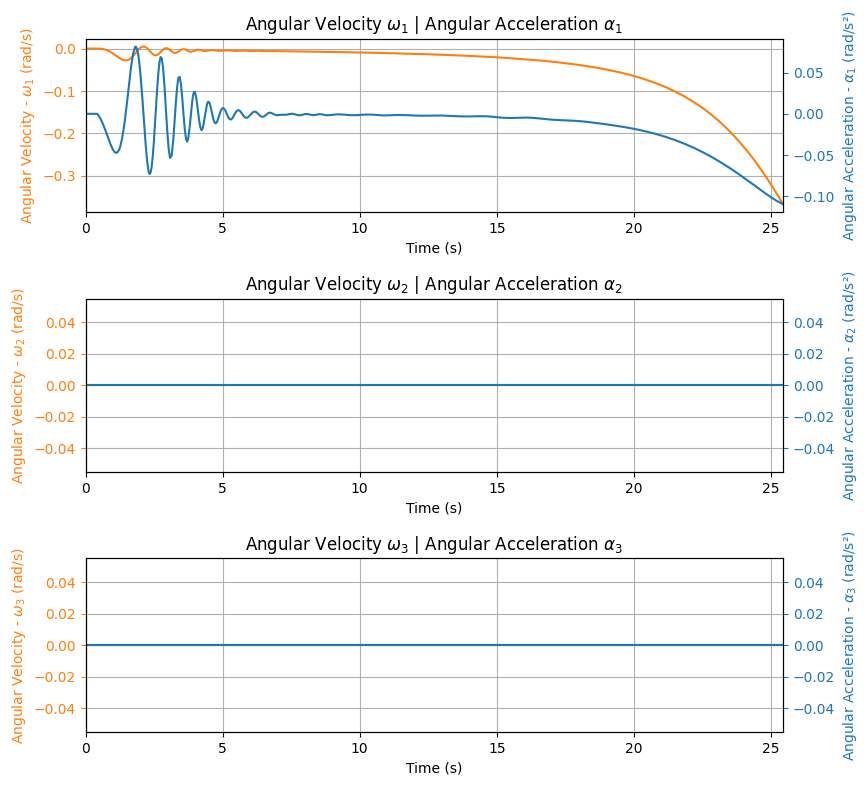



Aerodynamic Forces Plots



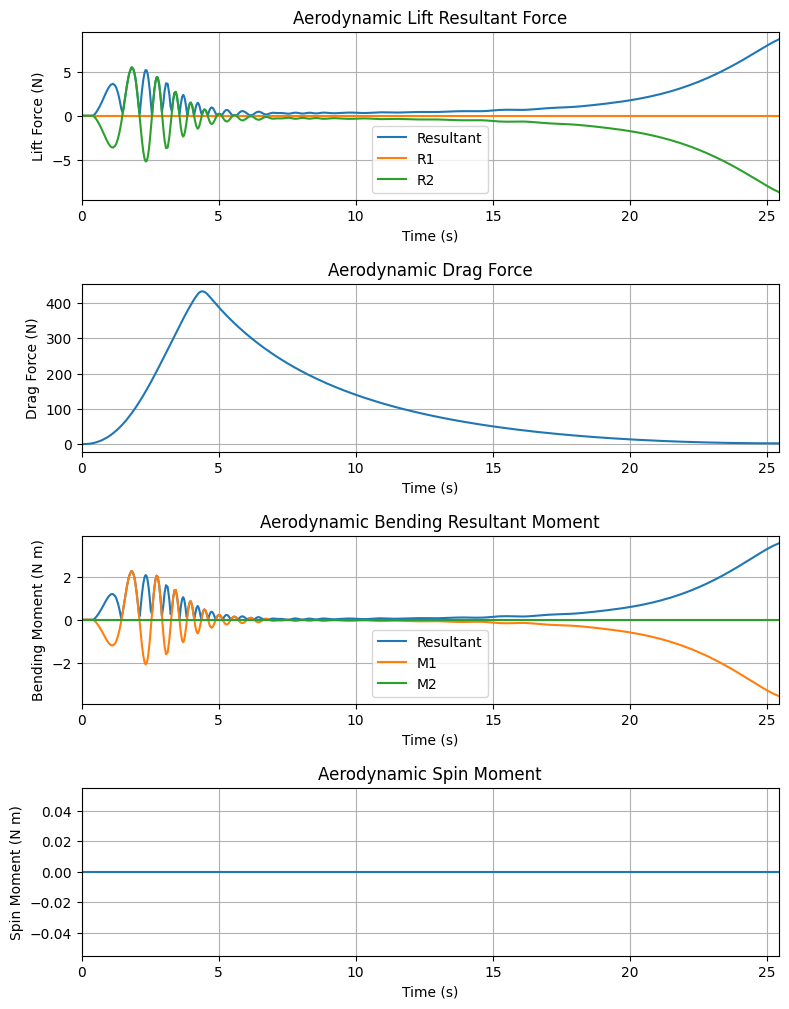



Rail Buttons Forces Plots



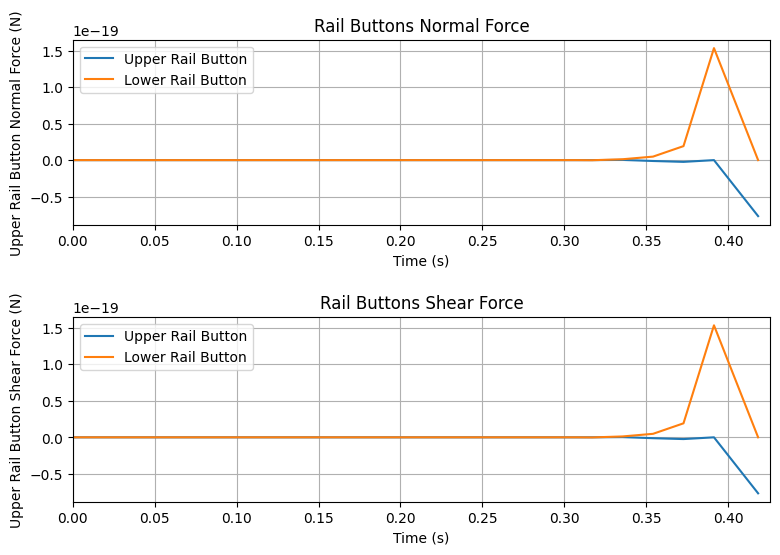



Trajectory Energy Plots



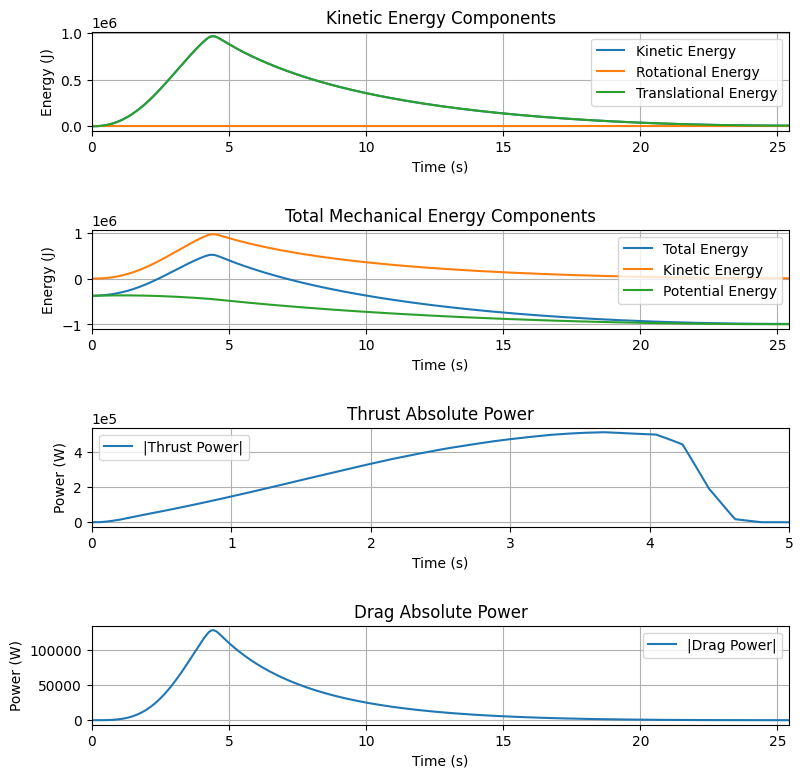



Trajectory Fluid Mechanics Plots



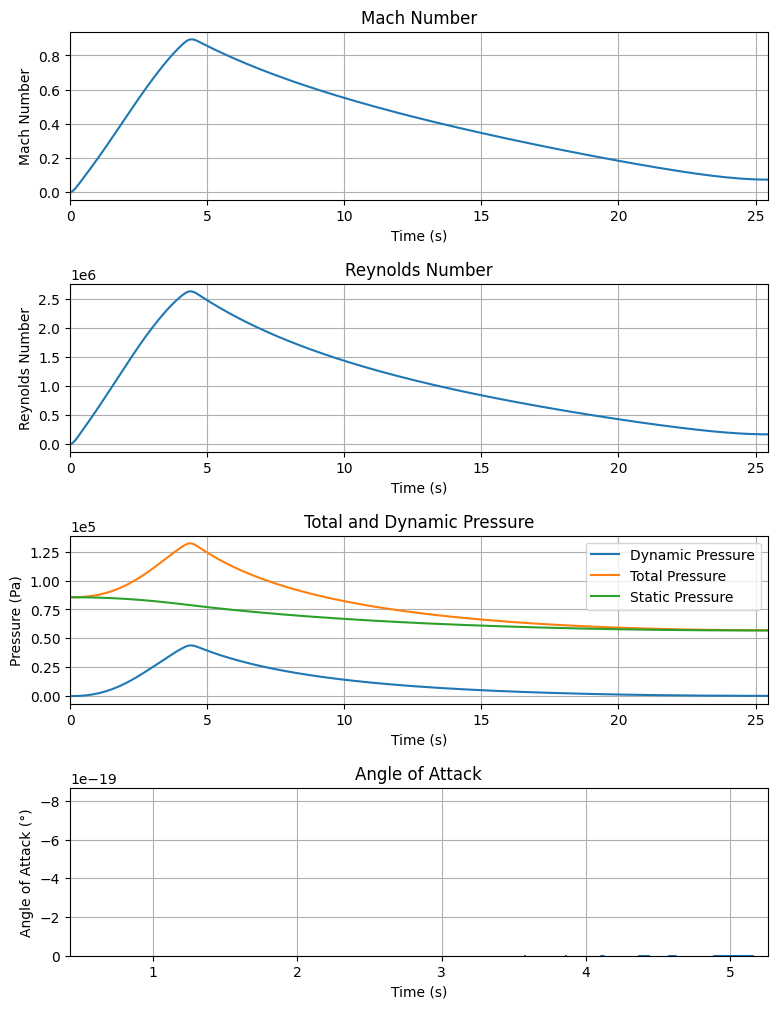



Trajectory Stability and Control Plots



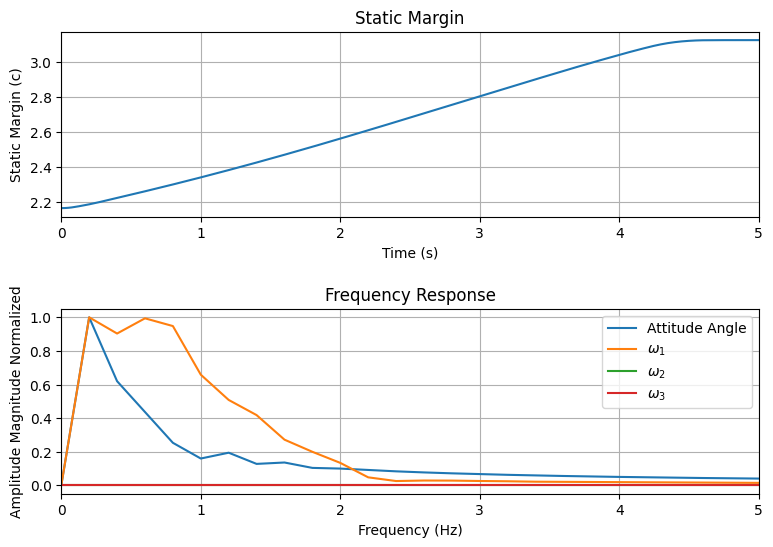



Rocket and Parachute Pressure Plots



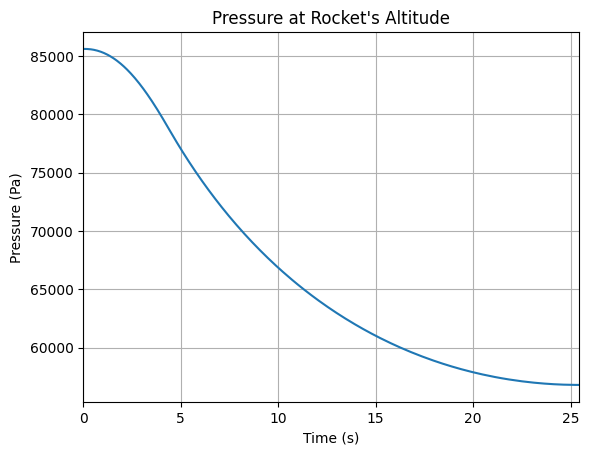


Rocket has no parachutes. No parachute plots available


In [7]:
nominal_flight = Flight(
    rocket = Sabre_1,
    environment = env,
    rail_length = 17 * 0.3048,
    inclination=84,
    heading = 0,
    terminate_on_apogee=True
)

print(f"Nominal Apogee: {nominal_flight.apogee - initial_height_m} m, {(nominal_flight.apogee - initial_height_m) * 3.28084} ft")
nominal_flight.z.plot(0, nominal_flight.apogee_time)
nominal_flight.all_info()